In [116]:
import gurobipy as gp
from gurobipy import *
import pandas as pd
import numpy as np
import matplotlib.pylab as plt
from math import sqrt
import seaborn as sns 
from random import sample

### Short-Term Optimization - Maximize Expected Profits at One Specific Day

In [117]:
data = pd.read_csv('op_data_1.csv')

In [118]:
# check data
data.head(5)

,Name,Open,Close
0,Celsius,5.866648,5.923342
1,IOTA,1.042717,1.013511
2,Axie Infinity,73.688873,74.772003
3,chainlink,26.040000,25.720000
4,PAX Gold,1822.720825,1821.315063


### Set up model parameters

In [119]:
budget = 100000 #  the amount of money invested (budget)
openprice = data['Open'] # the open price for each crypto i 
close = data['Close'] # the close price for each crypto i
percentage = 0.3 # percentage of investment funds in any single crypto

### Set up model index

In [120]:
crypto_number = range(len(data))

### Set up model

In [121]:
m = Model() 
x = m.addVars(crypto_number,vtype=GRB.INTEGER, lb = 0.0) # the amount of crypto i purchased on Aug 28th, 2021

In [122]:
# maximize short-term expeced profits
m.setObjective(sum((close[i] - openprice[i]) *x[i] for i in crypto_number))
m.modelSense = GRB.MAXIMIZE

### Set up constraints

In [123]:
# total amount of cryptos purchased should be less than the budget
m.addConstr(sum(openprice[i]*x[i] for i in crypto_number)<= budget)

<gurobi.Constr *Awaiting Model Update*>

In [124]:
# each kind of crypto purchased should be less than 30% 
for i in crypto_number:
    m.addConstr( openprice[i] * x[i] <= percentage * budget )

In [125]:
# domain constraints
for i in crypto_number:
    m.addConstr( x[i] >= 0.0 )

In [126]:
m.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 187 rows, 93 columns and 279 nonzeros
Model fingerprint: 0x8fcc3928
Variable types: 0 continuous, 93 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-06, 5e+04]
  Objective range  [1e-05, 5e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 1e+05]
Found heuristic solution: objective 1720.2477042
Presolve removed 186 rows and 59 columns
Presolve time: 0.00s
Presolved: 1 rows, 34 columns, 34 nonzeros
Variable types: 0 continuous, 34 integer (0 binary)
Found heuristic solution: objective 1755.9758000

Root relaxation: objective 3.138630e+04, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 31386.3036    0    1 1755.97580 31386.3036  168

In [127]:
# print the maximum expected profits
print(m.objVal) 

31386.13443890914


In [128]:
# optimal investment plan 
for i in crypto_number:
    if x[i].x != 0: 
        print(data['Name'][i], 'should buy: ', x[i].x)

Bitcoin Gold should buy:  431.0
eCash should buy:  319145739.0
Loopring should buy:  20217.0
Arweave should buy:  778.0


### Short-Term Optimization - Maximize Expected Profits at One Specific Day Using Machine Learning Prediction Results

In [129]:
# Machine learning prediction data 
MLdata = pd.read_csv('output_ML.csv')
ML_open = MLdata['Actual 2021.8.28 Open']
predict_close = MLdata['Predicted 8.28 Close']

# set up index 
ml_number = range(len(MLdata))

# set up model 
ml_model = Model() 
xml = ml_model.addVars(ml_number,vtype=GRB.INTEGER) # the amount of crypto i purchased on Aug 28th, 2021

# maximize short-term expeced revenue
ml_model.setObjective(sum((predict_close[i] - ML_open[i]) *xml[i] for i in ml_number))
ml_model.modelSense=GRB.MAXIMIZE

# set up constraints
# total amount of cryptos purchased should be less than the budget
ml_model.addConstr(sum(ML_open[i]*xml[i] for i in ml_number)<= budget)

# each kind of crypto purchased should be less than 30% 
for i in ml_number:
    ml_model.addConstr(ML_open[i] * xml[i] <= percentage * budget)
    

# domain constraints
for i in ml_number:
    ml_model.addConstr(xml[i] >= 0.0 )
    
ml_model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 187 rows, 93 columns and 279 nonzeros
Model fingerprint: 0x7de6a6a5
Variable types: 0 continuous, 93 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-06, 5e+04]
  Objective range  [4e-09, 2e+03]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 1e+05]
Found heuristic solution: objective 1279.3662549
Presolve removed 186 rows and 35 columns
Presolve time: 0.00s
Presolved: 1 rows, 58 columns, 58 nonzeros
Variable types: 0 continuous, 58 integer (0 binary)
Found heuristic solution: objective 1299.7669816

Root relaxation: objective 7.971056e+03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 7971.05569    0    1 1299.76698 7971.05569   51

In [130]:
# ML optimization results
# print the maximum expected revenue
print(ml_model.objVal) 

# optimal investment plan
for i in ml_number:
    if xml[i].x != 0: 
        print(MLdata['crypto'][i], 'should buy: ', xml[i].x)

7971.0534640897495
Lido DAO should buy:  4940.0
Shiba Inu should buy:  1.0
Trust Wallet Token should buy:  11119.0
dogecoin should buy:  103566.0
eCash should buy:  319148084.0


In [131]:
MLprofit = 0

for i in ml_number:
    if xml[i].x != 0:
        MLprofit += ((data[data['Name'] == MLdata['crypto'][i]]['Close'] - data[data['Name'] == MLdata['crypto'][i]]['Open']) * xml[i].x).to_numpy()[0]

print("ML actual profit: " + str(MLprofit))

ML actual profit: 18088.251671886937


### Short-Term Optimization - Maximize Expected Profits at One Specific Day Using ARIMA Prediction Results

In [132]:
# ARIMA prediction data 
ARdata = pd.read_csv('output_ARIMA.csv')
AR_open = ARdata['actual price 8.28']
predict_close_AR = ARdata['pred price 8.28']

# set up index 
AR_number = range(len(ARdata))

# set up model 
AR_model = Model() 
xar = AR_model.addVars(AR_number,vtype=GRB.INTEGER) # the amount of crypto i purchased on Aug 28th, 2021

# maximize short-term expeced revenue
AR_model.setObjective(sum((predict_close_AR[i] - AR_open[i]) *xar[i] for i in AR_number))
AR_model.modelSense=GRB.MAXIMIZE

# set up constraints
# total amount of cryptos purchased should be less than the budget
AR_model.addConstr(sum(AR_open[i]*xar[i] for i in AR_number)<= budget)

# each kind of crypto purchased should be less than 30% 
for i in AR_number:
    AR_model.addConstr(AR_open[i] * xar[i] <= percentage * budget)
    

# domain constraints
for i in AR_number:
    AR_model.addConstr(xar[i] >= 0.0 )
    
AR_model.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 187 rows, 93 columns and 279 nonzeros
Model fingerprint: 0x9bd8807d
Variable types: 0 continuous, 93 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-06, 5e+04]
  Objective range  [2e-07, 3e+02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+04, 1e+05]
Found heuristic solution: objective 2284.6219082
Presolve removed 186 rows and 71 columns
Presolve time: 0.00s
Presolved: 1 rows, 22 columns, 22 nonzeros
Variable types: 0 continuous, 22 integer (0 binary)
Found heuristic solution: objective 2287.9128583

Root relaxation: objective 3.667620e+03, 1 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Gap | It/Node Time

     0     0 3667.62019    0    1 2287.91286 3667.62019  60.

In [133]:
# ARIMA optimization results
# print the maximum expected revenue
print(AR_model.objVal) 

# optimal investment plan
for i in AR_number:
    if xar[i].x != 0: 
        print(ARdata['crypto'][i], 'should buy: ', xar[i].x)

3667.575294062146
Internet Computer should buy:  478.0
STEPN should buy:  1068.0
Holo should buy:  2135277.0
Qtum should buy:  2330.0


In [134]:
ARprofit = 0

for i in AR_number:
    if xar[i].x != 0:
        ARprofit += ((data[data['Name'] == ARdata['crypto'][i]]['Close'] - data[data['Name'] == ARdata['crypto'][i]]['Open']) * xar[i].x).to_numpy()[0]

print("ARIMA actual profit: " + str(ARprofit))

ARIMA actual profit: 2740.8459321884884


### Long-Term Optimization - Optimize Expected Profits while Minimizing Portfolio Risk

In [135]:
data2 = pd.read_csv('op_data_3.csv')
data2.head(5)

,Date,Celsius,IOTA,Axie Infinity,chainlink,PAX Gold,Hedera,bitcoin cash,Kava,Elrond,...,TrueUSD,tron,Fantom,BNB,Chiliz,Filecoin,Gala,Maker,OKB,avalanche
0,2021-07-28,5.953807,0.838982,45.687160,19.06,1812.750977,0.197005,510.69,5.299311,84.971237,...,1.000003,0.060688,0.226810,313.428650,0.251249,49.517242,0.028273,2653.447998,17.701300,12.28
1,2021-07-29,5.972963,0.847965,44.219723,19.37,1835.003906,0.204228,538.59,5.248055,85.020378,...,0.999887,0.061843,0.249234,316.749451,0.256158,49.371132,0.024827,2895.585693,18.221209,12.43
2,2021-07-30,6.267168,0.844172,43.332626,22.25,1824.856445,0.214838,552.49,5.292565,86.934517,...,1.000001,0.063204,0.253664,322.909363,0.265367,51.307907,0.021797,2917.430420,18.681316,12.97
3,2021-07-31,6.243934,0.934148,42.660290,22.68,1820.981567,0.214312,545.73,5.252579,86.107124,...,0.999884,0.063921,0.255758,333.549591,0.265691,52.200218,0.025415,2987.255127,19.441641,13.51
4,2021-08-01,6.110260,0.876294,37.948685,22.10,1815.259155,0.206148,526.71,5.251462,87.187996,...,0.999983,0.064058,0.246374,333.484009,0.260888,53.937824,0.022813,2921.900635,19.401009,12.86


### Set up model parameters

In [136]:
# drop date column 
data2 = data2.drop(columns = 'Date')

In [137]:
# Data preprocessing
closes = np.transpose(np.array(data2))    # matrix of daily closing prices
absdiff = np.diff(closes)           # change in closing price each day
reldiff = np.divide(absdiff, closes[:,:-1]) # relative change in daily closing price

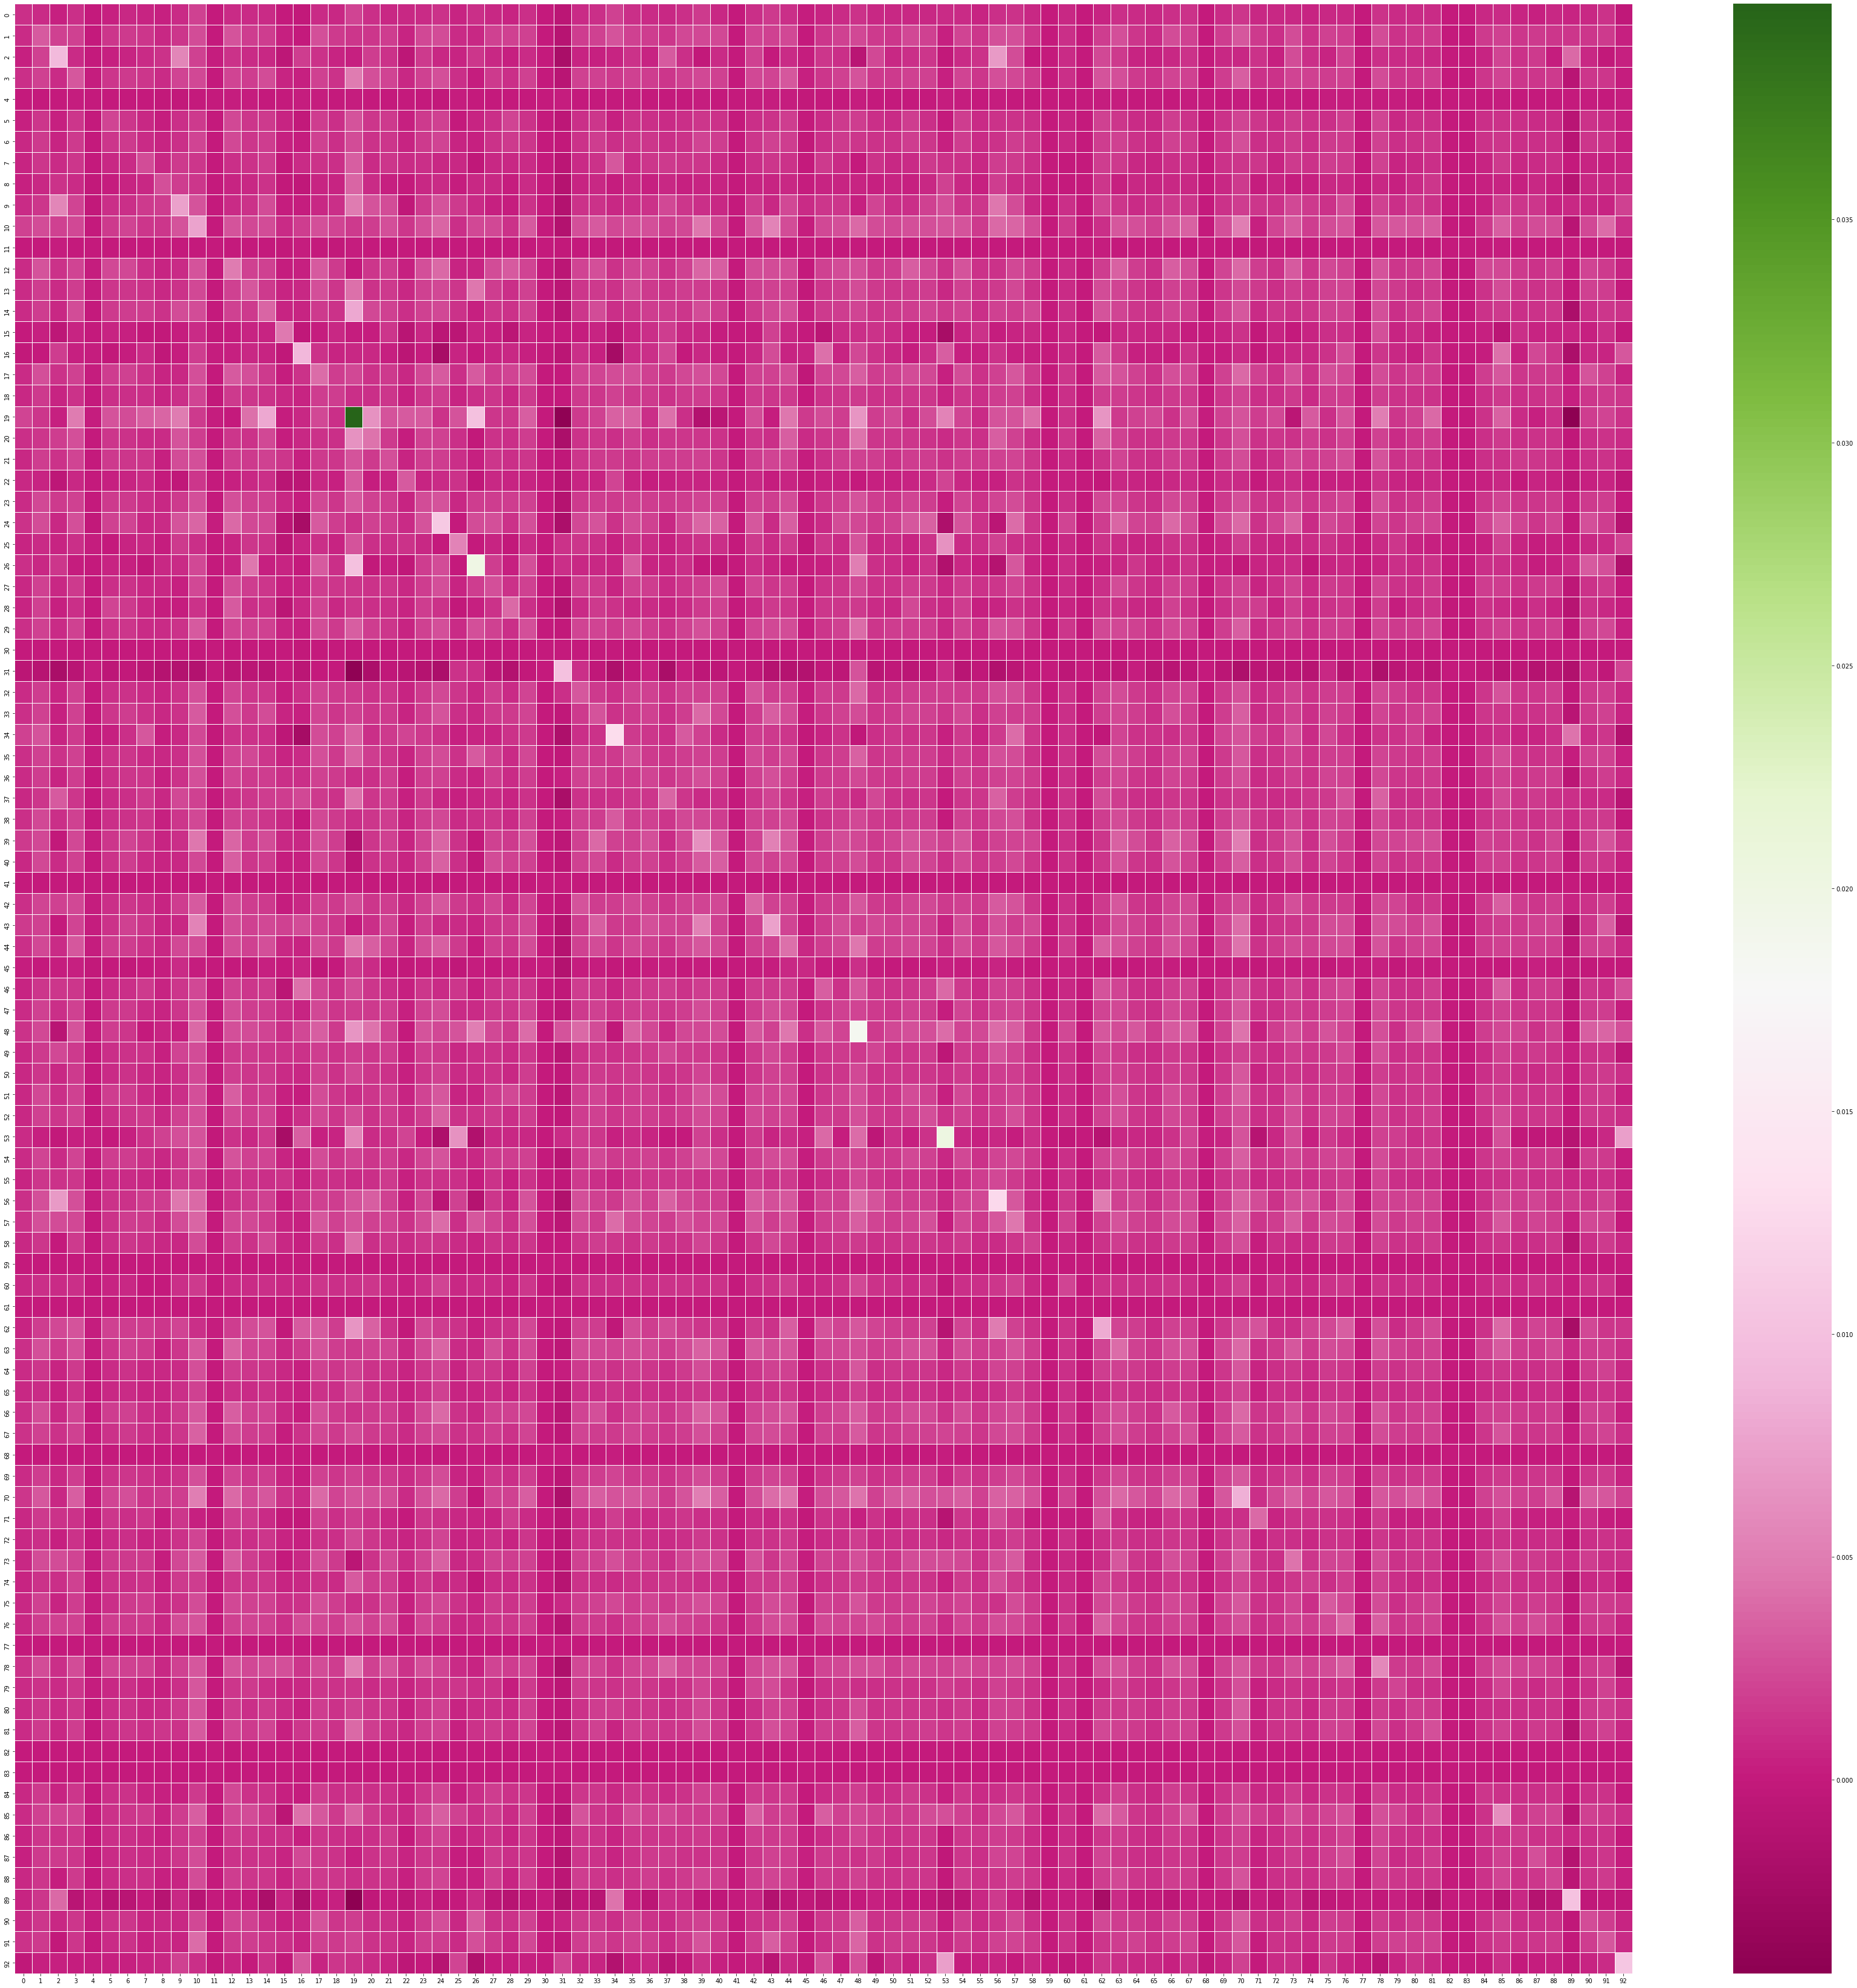

In [138]:
mu = np.mean(reldiff, axis=1)               # mean relative price change
sigma = np.cov(reldiff)                     # covariance (standard deviations)
std = np.std(reldiff, axis=1)               # standard deviation

plt.figure(figsize=(60,60))
ax = sns.heatmap(sigma, linewidth=0.5, cmap="PiYG")
plt.show()

In [139]:
# Create an empty model
m2 = gp.Model('portfolio')

# Add matrix variable for the cryptos
crypto_set = range(len(data2.columns))
x2 = m2.addVars(crypto_set, vtype=GRB.INTEGER, lb=0.0)

In [140]:
# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between cryptos
risk = sum(sum(sigma[i,j]*x2[i]*x2[j] for i in crypto_set) for j in crypto_set)

m2.setObjective(risk, GRB.MINIMIZE)

In [141]:
# total amount of cryptos purchased at the first day (open price on July 28, 2021) should be less than the budget
limit = 100
m2.addConstr( sum(openprice[i]*x2[i] for i in crypto_set) == limit)

# each kind of crypto purchased at the first day (open price on July 28, 2021)should be less than 30% 
for i in crypto_set:
    m2.addConstr(openprice[i] * x2[i] <= percentage * limit)

# domain constraints
for i in crypto_set:
    m2.addConstr(x2[i] >= 0.0)

# Optimize model to find the minimum risk portfolio
m2.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 187 rows, 93 columns and 279 nonzeros
Model fingerprint: 0xec1f0db1
Model has 4371 quadratic objective terms
Variable types: 0 continuous, 93 integer (0 binary)
Coefficient statistics:
  Matrix range     [7e-06, 5e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-10, 8e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Found heuristic solution: objective 1.354217e+11
Presolve removed 186 rows and 28 columns
Presolve time: 0.00s
Presolved: 1 rows, 65 columns, 65 nonzeros
Presolved model has 2145 quadratic objective terms
Variable types: 0 continuous, 65 integer (9 binary)

Root relaxation: objective 1.611437e-04, 37 iterations, 0.00 seconds (0.00 work units)

    Nodes    |    Current Node    |     Objective Bounds      |     Work
 Expl Unexpl |  Obj  Depth IntInf | Incumbent    BestBd   Ga

In [142]:
# the optimal value
print(m2.objVal)

0.00025900279382431497


In [143]:
# optimal investment plan 
for i in crypto_set:
    if x2[i].x != 0: 
        print(data2.columns[i], 'should buy: ', x2[i].x)

Binance USD should buy:  30.0
tether should buy:  29.0
Pax Dollar should buy:  1.0
usd coin should buy:  22.0
dai should buy:  9.0
TrueUSD should buy:  9.000055088049521


### Long-Term Optimization - To Produce Risk-Return frontier

In [144]:
# data processing to improve running time
selected_crypto = []
select_crypto_idx = [i for i in range(0,92,1)]

for i in select_crypto_idx:
    selected_crypto.append(list(data2.columns)[i])

data3 = data2[selected_crypto]
data3.head()

,Celsius,IOTA,Axie Infinity,chainlink,PAX Gold,Hedera,bitcoin cash,Kava,Elrond,Helium,...,dai,TrueUSD,tron,Fantom,BNB,Chiliz,Filecoin,Gala,Maker,OKB
0,5.953807,0.838982,45.687160,19.06,1812.750977,0.197005,510.69,5.299311,84.971237,12.825875,...,1.0013,1.000003,0.060688,0.226810,313.428650,0.251249,49.517242,0.028273,2653.447998,17.701300
1,5.972963,0.847965,44.219723,19.37,1835.003906,0.204228,538.59,5.248055,85.020378,12.364539,...,1.0014,0.999887,0.061843,0.249234,316.749451,0.256158,49.371132,0.024827,2895.585693,18.221209
2,6.267168,0.844172,43.332626,22.25,1824.856445,0.214838,552.49,5.292565,86.934517,14.250572,...,1.0010,1.000001,0.063204,0.253664,322.909363,0.265367,51.307907,0.021797,2917.430420,18.681316
3,6.243934,0.934148,42.660290,22.68,1820.981567,0.214312,545.73,5.252579,86.107124,13.803126,...,1.0014,0.999884,0.063921,0.255758,333.549591,0.265691,52.200218,0.025415,2987.255127,19.441641
4,6.110260,0.876294,37.948685,22.10,1815.259155,0.206148,526.71,5.251462,87.187996,13.128343,...,1.0014,0.999983,0.064058,0.246374,333.484009,0.260888,53.937824,0.022813,2921.900635,19.401009


In [145]:
# reset series index (or else there will be an error afterwards)
selected_open = openprice.iloc[select_crypto_idx]
selected_open = selected_open.reset_index()['Open']
selected_open

0        5.866648
1        1.042717
2       73.688873
3       26.040000
4     1822.720825
         ...     
87       0.378136
88      75.224503
89       0.031302
90    3752.024414
91      20.875673
Name: Open, Length: 92, dtype: float64

In [146]:
closes_m3 = np.transpose(np.array(data3))    # matrix of daily closing prices
absdiff_m3 = np.diff(closes_m3)           # change in closing price each day
reldiff_m3 = np.divide(absdiff_m3, closes_m3[:,:-1])

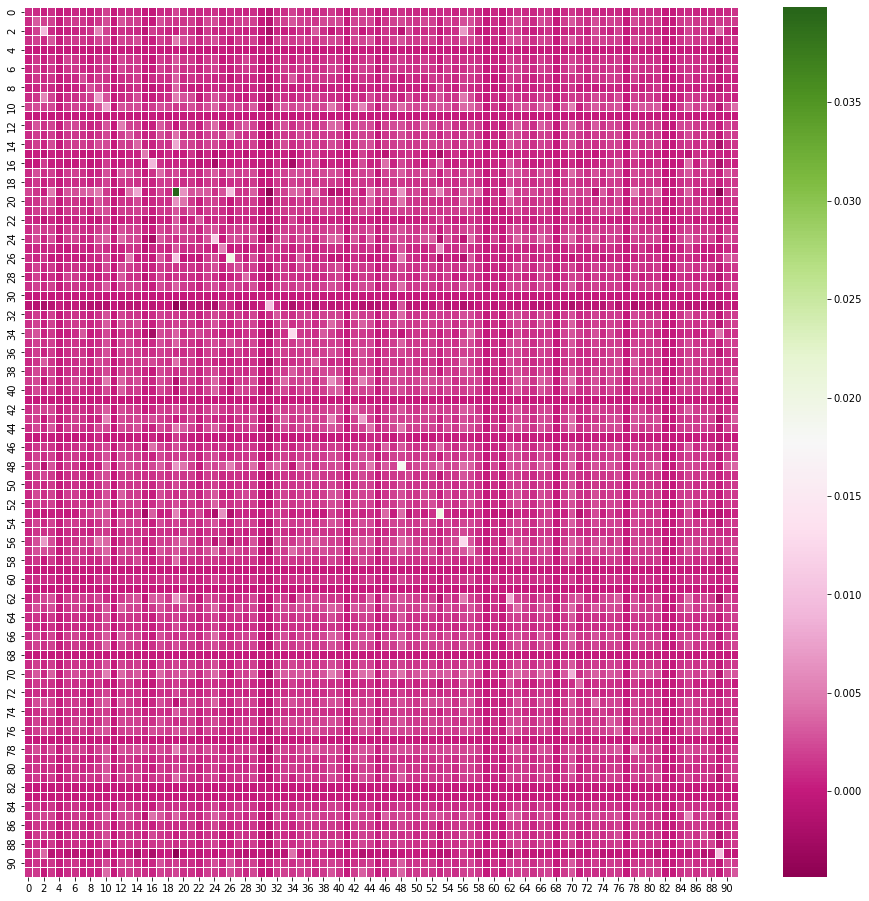

In [147]:
mu3 = np.mean(reldiff_m3, axis=1)               # mean relative price change
sigma3 = np.cov(reldiff_m3)                     # covariance (standard deviations)
std3 = np.std(reldiff_m3, axis=1)               # standard deviation

plt.figure(figsize=(16,16))
ax = sns.heatmap(sigma3, linewidth=0.5, cmap="PiYG")
plt.show()

In [148]:
# Create an empty model
m3 = gp.Model('model3')

# Add matrix variable for the cryptos
select_crypto_set = range(len(data3.columns))

In [149]:
x3 = m3.addVars(select_crypto_set, lb=0.0)

# Objective is to minimize risk (squared).  This is modeled using the
# covariance matrix, which measures the historical correlation between cryptos
risk = sum(sum(sigma3[i,j]*x3[i]*x3[j] for i in select_crypto_set) for j in select_crypto_set)

m3.setObjective(risk, GRB.MINIMIZE)

In [150]:
# total amount of cryptos purchased at the first day (open price on July 28, 2021) should be less than the budget
m3.addConstr(sum(selected_open[i]*x3[i] for i in select_crypto_set) == limit)

# each kind of crypto purchased at the first day (open price on July 28, 2021)should be less than 30% 
for i in select_crypto_set:
    m3.addConstr(selected_open[i] * x3[i] <= percentage * limit)

# domain constraints
for i in select_crypto_set:
    m3.addConstr(x3[i] >= 0.0)

m3.optimize()

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 185 rows, 92 columns and 276 nonzeros
Model fingerprint: 0x7dc2766e
Model has 4278 quadratic objective terms
Coefficient statistics:
  Matrix range     [7e-06, 5e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-10, 8e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [3e+01, 1e+02]
Presolve removed 184 rows and 0 columns
Presolve time: 0.00s
Presolved: 1 rows, 92 columns, 92 nonzeros
Presolved model has 4278 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 30
 AA' NZ     : 4.650e+02
 Factor NZ  : 4.960e+02
 Factor Ops : 1.042e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   6.62061339e-02 -6.16750788e+08  6.00e+06 1.20e-01  1.43e+08 

In [151]:
sol_volatility = sqrt(m3.objVal)
sol_return = sum(mu3[i] * x3[i].x for i in select_crypto_set)


pd.DataFrame(data = np.append([x3[i].x for i in select_crypto_set], [sol_volatility, sol_return]),
             index= selected_crypto + ['Volatility', 'Expected Return'],
             columns=['Minimum Risk Portfolio'])

# Create an expression representing the expected return for the portfolio
portfolio_return = sum(mu3[i] * x3[i] for i in select_crypto_set)

target = m3.addConstr(portfolio_return == 0)

# Solve for efficient frontier by varying target return
frontier = np.empty((2,0))
for r in np.linspace(mu3.min(), mu3.max(), 100):
    target.rhs = r
    m3.optimize()
    frontier = np.append(frontier, [[sqrt(m3.objVal)],[r]], axis=1)

Gurobi Optimizer version 9.5.2 build v9.5.2rc0 (mac64[rosetta2])
Thread count: 10 physical cores, 10 logical processors, using up to 10 threads
Optimize a model with 186 rows, 92 columns and 368 nonzeros
Model fingerprint: 0x33552e3a
Model has 4278 quadratic objective terms
Coefficient statistics:
  Matrix range     [5e-07, 5e+04]
  Objective range  [0e+00, 0e+00]
  QObjective range [2e-10, 8e-02]
  Bounds range     [0e+00, 0e+00]
  RHS range        [2e-03, 1e+02]
Presolve removed 184 rows and 0 columns
Presolve time: 0.00s
Presolved: 2 rows, 92 columns, 184 nonzeros
Presolved model has 4278 quadratic objective terms
Ordering time: 0.00s

Barrier statistics:
 Free vars  : 30
 AA' NZ     : 4.960e+02
 Factor NZ  : 5.280e+02
 Factor Ops : 1.144e+04 (less than 1 second per iteration)
 Threads    : 1

                  Objective                Residual
Iter       Primal          Dual         Primal    Dual     Compl     Time
   0   4.37988566e-14 -6.85571375e+03  4.21e+04 1.15e-07  6.46e+05

IOPub message rate exceeded.
The notebook server will temporarily stop sending output
to the client in order to avoid crashing it.
To change this limit, set the config variable
`--NotebookApp.iopub_msg_rate_limit`.

Current values:
NotebookApp.iopub_msg_rate_limit=1000.0 (msgs/sec)
NotebookApp.rate_limit_window=3.0 (secs)



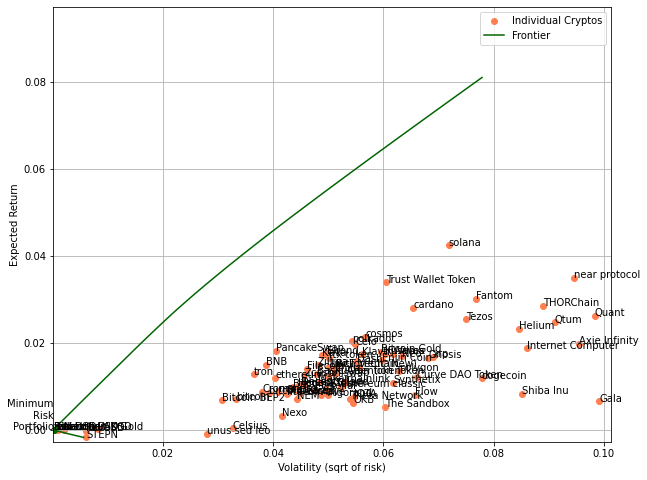

In [152]:
fig, ax = plt.subplots(figsize=(10,8))

# Plot volatility versus expected return for individual cryptos
ax.scatter(x=std3, y=mu3, color='Coral', label='Individual Cryptos')
for i, crypto in enumerate(list(data3.columns)):
    ax.annotate(crypto, (std3[i], mu3[i]))

# Plot volatility versus expected return for minimum risk portfolio
ax.scatter(x=sol_volatility, y=sol_return, color='DarkGreen')
ax.annotate('Minimum\nRisk\nPortfolio', (sol_volatility, sol_return),
            horizontalalignment='right')

# Plot efficient frontier
ax.plot(frontier[0], frontier[1], label='Frontier', color='DarkGreen')

# Format and display the final plot
ax.axis([frontier[0].min() - 0.6*np.abs(frontier[0].min()), frontier[0].max()*1.3, mu3.min() - 0.6*np.abs(mu3.min()), mu3.max()*1.2])
ax.set_xlabel('Volatility (sqrt of risk)')
ax.set_ylabel('Expected Return')
ax.legend()
ax.grid()
plt.show()